<a href="https://colab.research.google.com/github/matheusprandini/ml-games-course/blob/main/docs/Redes_Neurais_Jogo_Catch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tratamento de Dados e Treinamento de Modelos

Esse Jupyter Notebook tem como objetivo auxiliar no entendimento do processo de coleta e preparação de dados, além da construção, compilação e treinamento de modelos de redes neurais MultiLayer Perceptron (MLP) usado em: https://github.com/matheusprandini/ml-games-course/.

## Importando as bibliotecas necessárias

- Cv2: biblioteca útil para manipulação de imagens.
- Matplotlib: construção de visualizações (gráficos e etc).
- Numpy: responsável por otimizar operações em vetores e matrizes.
- Pandas: simplifica a manipulação de dados em dataframes.
- Keras: framework para criação de modelos de redes neurais.

Além disso, foi importada a função `shuffle` do módulo `random`. Ela tem como objetivo "bagunçar" (mudar a ordem) dos elementos em uma lista.

In [ ]:
# TensorFlow e tf.keras
from tensorflow import keras

# Bibliotecas Auxiliares
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle

## Carregando os Dados

Os dados de exemplo estão nesse link: https://drive.google.com/file/d/1TdZ0hEPMoY8fCk-mtA-36gcVaN7EKomv/view?usp=sharing. Ele contém tuplas (imagem crua, ação realizada) de 5 partidas do jogo Catch. Basta realizar o download do arquivo e fazer o upload do mesmo aqui no nootebook.

O upload pode ser realizado da seguinte forma:

- Na aba do lado esquerdo, entre na pasta chamada `Arquivos`.
- Clique em `Fazer upload para o armazenamento da sessão`.
- Escolha o arquivo baixado.


Espere o upload finalizar para continuar os próximos passos.

### Informações a respeito dos dados carregados

Cada partida do jogo Catch é composto por:
- 16 exemplos (totalizando 80 exemplos em 5 jogos).
- Imagens de dimensão 400x400x3 (altura e largura iguais a 400 e 3 canais de cores por conta d a representação RGB).
- 3 classes (ações do jogador: não fazer nada, mover para a esquerda e para a direita).

**Obs: cada exemplo é representado por uma tupla formada pela imagem de jogo e a ação executada pelo agente supervisor para tal imagem.**

In [ ]:
catch_data_path = "/content/raw_catch_5_games.npy"
data = list(np.load(catch_data_path, allow_pickle=True))

In [ ]:
print(f"Número Total de Exemplos: {len(data)}")
print(f"Tamanho das Imagens: {data[0][0].shape}")
print(f"Número de Classes: {len(set([elem[1] for elem in data]))}")

Número Total de Exemplos: 80
Tamanho das Imagens: (400, 400, 3)
Número de Classes: 3


In [ ]:
classes_translator = {
    -1: 'Nothing', # Nada
    0: 'Left', # Esquerda
    1: 'Right', # Direita
}

### Visualização dos exemplos em sequência de uma partida

É possível notar que o agente manteve a plataforma parada na maior parte do tempo (não realizou nenhuma ação), movendo para a esquerda para garantir que capturaria o bloco que estava caindo.

Obs: a sequência deve ser visualizada da esquerda para a direita e de cima para baixo.

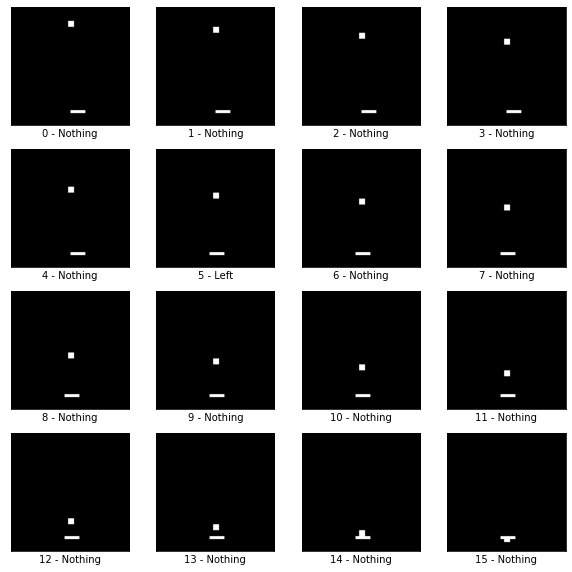

In [ ]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i][0], cmap=plt.cm.binary)
    plt.xlabel(f"{i} - {classes_translator[data[i][1]]}")
plt.show()

## Coleta e Preparação dos Dados

Essa seção é destinada a explicação das etapas utilizadas durante a coleta e preparação dos dados.

### Coleta dos Dados

A cada passo de tempo do jogo, o ambiente fornece uma imagem crua (*frame* em seu estado original) ao agente, o qual efetua uma ação no mesmo. Esse ciclo se repete ao longo do processo de coleta de dados.

A fim de otimizar o espaço a ser armazenado pelos dados coletados, as etapas de pré-processamento foram realizadas durante tal processo de coleta. Tais etapas são as seguintes:

- **Conversão da Cor da Imagem:** por padrão, o PyGame realiza a captura das imagens no padrão BGR (Blue, Green, Red). Por isso, é necessário converter esse padrão para algum outro caso seja desejado. No caso, utilizamos os padrões `GRAY` (Grayscale - Escala de Cinza) ou `RGB` (Red, Green, Blue).

- **Redimensionamento da Imagem:** utilizar as imagens em seus tamanhos originais pode influenciar negativamente nos modelos de redes neurais. Esses tamanhos estão diretamento relacionados à complexidade das redes em termos do número de parâmetros (dimensão do vetor de pesos), uma vez que quando maior o tamanho da entrada, mais pesos serão necessários para o processamento das imagens. Portanto, é realizado a etapa de redimensionamento, para padronizar um tamanho que seja adequado pensando na complexidade dos modelos. No caso, as imagens são redimensionadas para o tamanho 32x32 (32 pixels de altura e de largura).

- **Normalização Pixel-Wise:** responsável por efetuar a normalização dos pixels da imagem no intervalo entre 0 a 1. Isso auxilia na convergência do treinamento dos modelos.



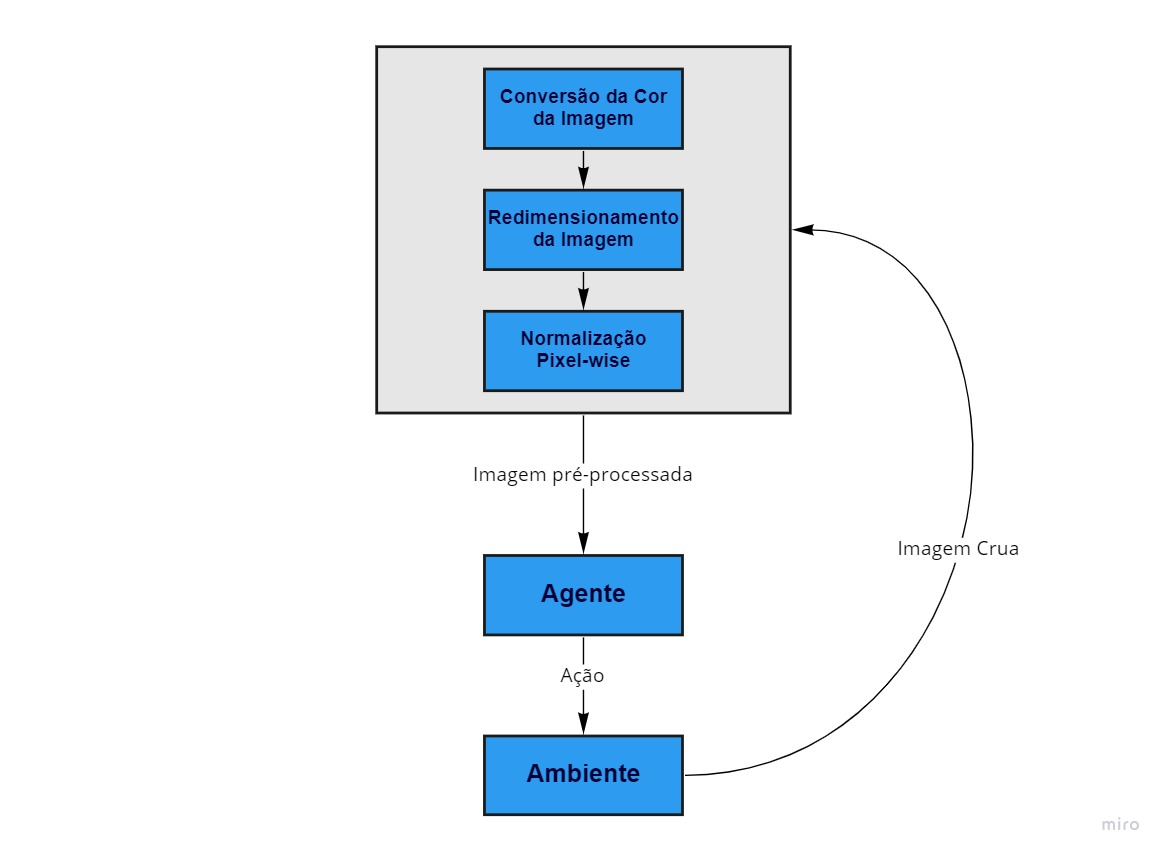

#### Visualizando um exemplo antes do pré-processamento

É possível observar que o tamanho original é de 400 pixels de altura por 400 pixels de largura (além dos 3 canais de cores BGR) e que o valor dos pixels varia no intervalo de 0 a 255. 

In [ ]:
def plot_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

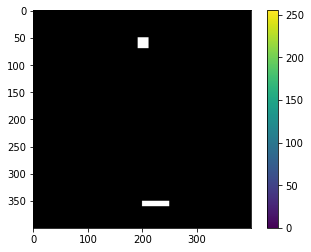

In [ ]:
frame = data[0][0]
plot_image(frame)

#### Aplicação do pré-processamento

##### **Conversão da Cor da Imagem:** realiza a transformação para o padrão `GRAY` (Grayscale - Escala de Cinza).

In [ ]:
def convert_frame_color(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

##### **Redimensionamento da Imagem:** converte a imagem para 32 pixels de altura para 32 pixels de largura.

In [ ]:
def resize_frame(frame, size=(32, 32)):
    return cv2.resize(frame, size)

##### **Normalização Pixel-Wise:** normalização dos pixels no intervalo 0 a 1.

In [ ]:
def apply_pixel_wise_normalization(frame):
    return (frame.astype('float32') / 255.0)

##### Pré-processamento completo

In [ ]:
def preprocess_frame(frame):
    operations = [
      convert_frame_color,
      resize_frame,
      apply_pixel_wise_normalization
    ]

    for operation in operations:
        frame = operation(frame)

    return frame

#### Visualização de um exemplo após o pré-processamento

Nota-se que agora o tamanho da imagem é de 32 pixels de altura por 32 pixels de largura (e apenas 1 canal de cor GRAY) e que o valor dos pixels varia no intervalo de 0 a 1. 

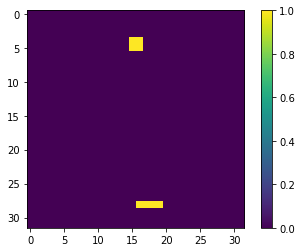

In [ ]:
preprocessed_frame = preprocess_frame(frame)
plot_image(preprocessed_frame)

#### Realização do Pré-processamento nos dados coletados

Após o pré-processamento, é importante destacar que a natureza dos dados coletados não foi alterada. As mesmas características observadas nos dados crus ainda são as mesmas encontrada nos dados pré-processados.

In [ ]:
preprocessed_data = []

for example in data:
    frame = example[0]
    action = example[1]
    preprocessed_frame = preprocess_frame(frame)
    preprocessed_data.append([preprocessed_frame, action])

In [ ]:
print(f"Número Total de Exemplos: {len(preprocessed_data)}")
print(f"Tamanho das Imagens: {preprocessed_data[0][0].shape}")
print(f"Número de Classes: {len(set([elem[1] for elem in preprocessed_data]))}")

Número Total de Exemplos: 80
Tamanho das Imagens: (32, 32)
Número de Classes: 3


### Preparação dos Dados

Como as etapas de pré-processamento já foram efetuadas durante o processo de coleta, o processo de preparação ficou responsável por realizar as seguintes etapas: 

- **Balanceamento dos Dados:** consiste em garantir que cada classe terá o mesmo número de exemplos na base. Por exemplo, se há 2000 exemplos totais e 2 classes, sendo 1500 exemplos relativos a uma das classes e 500 a outra, essa etapa fará com que apenas 500 exemplos da primeira classe sejam considerados. Assim, cada classe tem o mesmo peso na base (por isso o termo balanceamento). Existem algumas técnicas que também pode ser utilizadas, como oversampling (aumentar o número de exemplos de classes com pouca representatividade) e undersampling (diminuir o número de exemplos e classes com muita representatividade).

- **Divisão dos Dados:** responsável por realizar a divisão dos dados em treinamento e teste. A divisão foi 80/20 (80% para treinamento e 20% destinada a teste). No caso, os dados foram selecionados aleatoriamente para formarem cada base.

- **Transformação dos Dados:** realiza ajustes finais nos dados de entrada e saída.

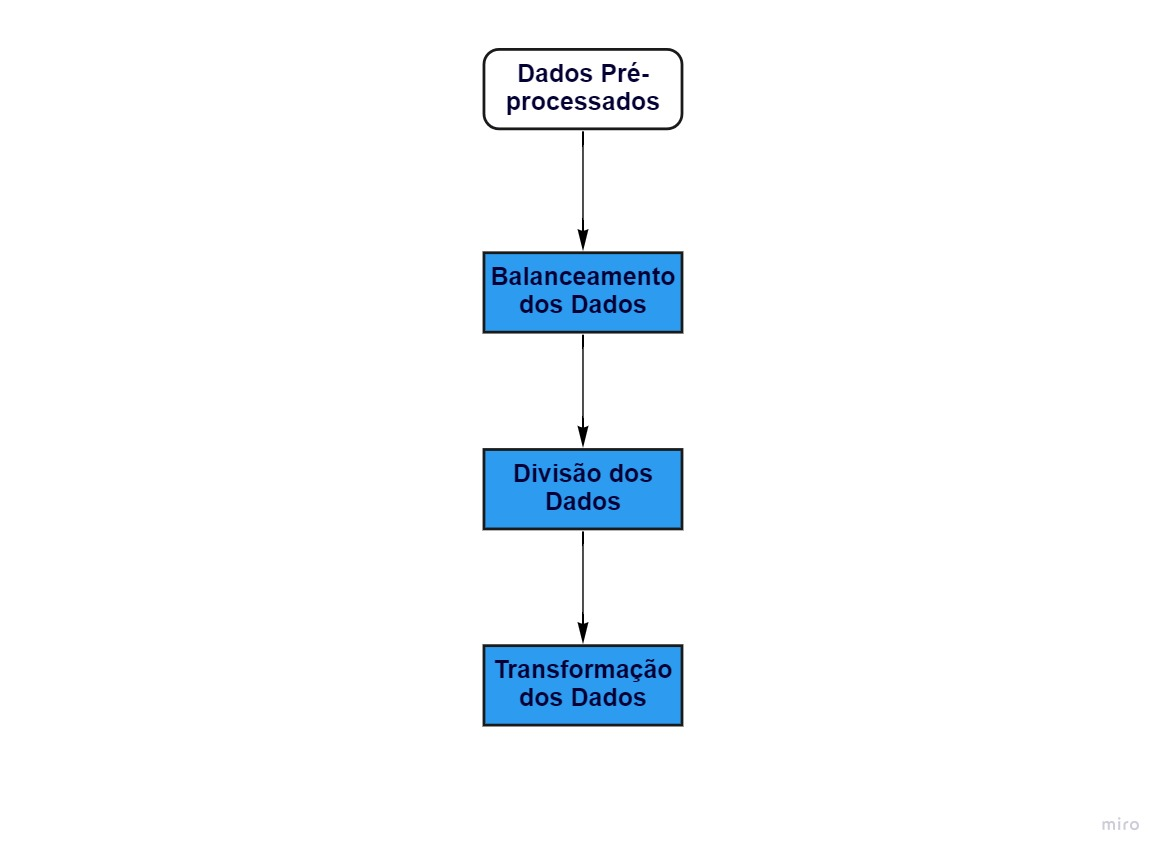

#### Balanceamento dos Dados

Essa etapa é realizada da seguinte forma:

- Agrupa-se o número de exemplos por classe.
- A classe com menor representatividade (ou seja, aquela com menos exemplos) é utilizada como referência.
- Para cada classe existente, seleciona-se um número de exemplos aletórios com base na referência (classe com menor representatividade).

Exemplo: suponha que nesse caso haja 3000 exemplos totais, sendo 1500 da classe 1, 1000 da classe 2 e 500 da classe 3. Serão selecionados 500 exemplos aletórios das classes 1 e 2 os 500 da classe 3 serão mantidos, formando um base com 1500 exemplos. Assim, cada classe agora possuirá a mesma representatividade. 

In [ ]:
def balance_data(data):
    df = pd.DataFrame(data, columns=['frame_representation', 'action'])
    num_examples_of_action_with_less_data = df.groupby(['action']).count().min().iloc[0]
    balanced_data = []

    unique_actions = df['action'].unique()
    for action in unique_actions:
        chosen_indexes = np.random.choice(
            df[df.action == action].index.values,
            num_examples_of_action_with_less_data
        )
        examples = df.loc[chosen_indexes].values.tolist()
        balanced_data.extend(examples)

    return balanced_data

In [ ]:
def show_unbalanced(data):
    df = pd.DataFrame(data, columns=['frame_representation', 'action'])
    print(df.groupby(['action']).count())

show_unbalanced(preprocessed_data)

        frame_representation
action                      
-1                        64
 0                         7
 1                         9


### Divisão (Separação) dos Dados de Entrada e Saída

Entrada = Imagem

Saída = Ação (classe)

In [ ]:
def split_data(data, split_fraction=0.8):
  input_data = []
  output_data = []
  shuffle(data)

  for example in data:
      img = example[0]
      output = example[1]
      input_data.append(img)
      output_data.append(output)

  split = int(split_fraction * len(data))

  inputs_train = input_data[:split]
  inputs_test = input_data[split:]
  labels_train = output_data[:split]
  labels_test = output_data[split:]

  return (inputs_train, labels_train, inputs_test, labels_test)

### Transformação dos Dados

Como iremos construir uma MLP, precisamos realizar alguns ajustes nos dados de entrada e de saída.

- **Ajuste nos dados de Entrada:** as imagens estavam no formato (32, 32), isto é, uma matriz de 32 por 32 pixels. Faremos uma transformação vetorizando a entrada para 1024 pixels. Essa é uma forma alternativa à camada `Flatten` utilizada no [Tutorial Keras](https://colab.research.google.com/drive/1esoolXTaxuwYyUwqM2P-7HgpfjK2kuG9?usp=**sharing**).

- **Ajuste nos dados de Saída:** as labels foram convertidas para a representação [one-hot enconding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). Dessa forma, a classe 0 fica representada pelo vetor [1,0,0], a classe 1 pelo vetor [0,1,0] e a classe -1 pelo vetor [0,0,1]. É possível observar que a classe -1 fica representada pela posição 2 (relacionada ao movimento `UP` no código), mas como o jogo Catch realiza apenas movimentos para a esquerda e para a direita, a ação para cima (`UP`) tem o mesmo efeito que não fazer nada.

In [ ]:
def transform_data(data):
  inputs_train = data[0]
  labels_train = data[1]
  inputs_test = data[2]
  labels_test = data[3]

  input_shape = inputs_train[0].shape
  converted_input_shape = (-1, np.prod(input_shape)) # O -1 aqui indica que não importa o número de exemplos, pode ser qualquer número.

  inputs_train = np.array(inputs_train).reshape(converted_input_shape)
  labels_train = keras.utils.to_categorical(labels_train, 3)
  inputs_test = np.array(inputs_test).reshape(converted_input_shape)
  labels_test = keras.utils.to_categorical(labels_test, 3)

  return (inputs_train, labels_train), (inputs_test, labels_test)

#### Exemplo one-hot-enconding

Dado um vetor com as classes -1, 0 e 1, o método do Keras `to_categorical` transforma tais valores para a representação one-hot enconding conforme mencionado acima.

In [ ]:
example = keras.utils.to_categorical([-1, 0, 1, 1, 0, 1, -1], 3)
example

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

### Aplicação de todos os passos de preparação

Podemos interpretar que essa preparação dos dados gerou apenas 21 exemplos após o balanceamento, que a divisão dos dados resultou em 16 exemplos de treinamento e 5 de teste, e que a transformação dos dados levou a uma vetorização das entradas para o tamanho 1024 e das saídas para tamanho 3 pela representação one-hot-encoding.  

In [ ]:
def handle_data(data):
    balanced_data = balance_data(data)
    splitted_data = split_data(balanced_data)
    return transform_data(splitted_data)

In [ ]:
(inputs_train, labels_train), (inputs_test, labels_test) = handle_data(
    preprocessed_data)

In [ ]:
print(f"Dimensão das entradas de treinamento: {inputs_train.shape}")
print(f"Dimensão das labels de treinamento: {labels_train.shape}")
print(f"Dimensão das entradas de teste: {inputs_test.shape}")
print(f"Dimensão das labels de teste: {labels_test.shape}")

Dimensão das entradas de treinamento: (16, 1024)
Dimensão das labels de treinamento: (16, 3)
Dimensão das entradas de teste: (5, 1024)
Dimensão das labels de teste: (5, 3)


## Definição e Treinamento de uma MLP

Essa seção apresenta a construção, a compilação, o treinamento e avaliação de uma MLP com os dados de exemplo do jogo Catch.

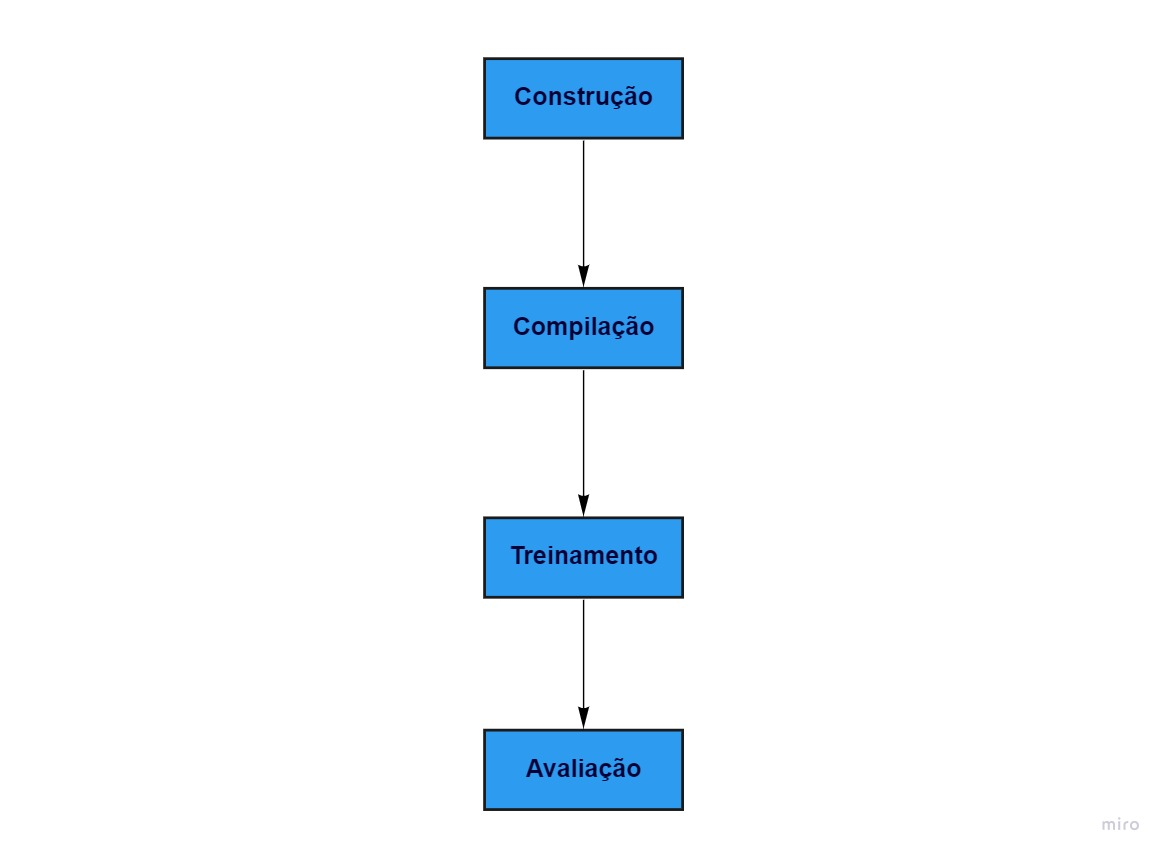

### Construção Modelo

Aqui foi construído um modelo bem simples de MLP, com apenas uma camada oculta composta por 128 neurônios e função de ativação `relu`, além da camada de saída composta por 3 neurônios (cada um representando uma das classes/ações) e pela função `softmax`. Tal rede possui um número de parâmetros (pesos) igual a 131.587.

In [ ]:
input_shape = (1024,)

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(128, activation='relu', input_shape=input_shape))
model.add(keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 131,587
Trainable params: 131,587
Non-trainable params: 0
_________________________________________________________________


### Compilação do Modelo

Foi utilizada a seguinte configuração:

- **Otimizador:** [Adam](https://acervolima.com/intuicao-de-adam-otimizador/).

- **Função Perda:** [erro quadrático médio](https://pt.wikipedia.org/wiki/Erro_quadr%C3%A1tico_m%C3%A9dio).

- **Métrica:** acurácia.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss='mean_squared_error', 
    metrics=['accuracy']
)

### Treinamento do Modelo

In [ ]:
model.fit(
    inputs_train,
    labels_train, 
    batch_size=4,
    epochs=5
)

Epoch 1/5
4/4 [==============================] - 1s 3ms/step - loss: 0.2185 - accuracy: 0.5000
Epoch 2/5
4/4 [==============================] - 0s 3ms/step - loss: 0.1965 - accuracy: 0.8125
Epoch 3/5
4/4 [==============================] - 0s 3ms/step - loss: 0.1788 - accuracy: 0.8750
Epoch 4/5
4/4 [==============================] - 0s 3ms/step - loss: 0.1618 - accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 0s 3ms/step - loss: 0.1450 - accuracy: 1.0000


### Avaliação do Modelo

In [ ]:
model.evaluate(inputs_test, labels_test)

1/1 [==============================] - 0s 118ms/step - loss: 0.1740 - accuracy: 0.8000


[0.17397572100162506, 0.800000011920929]

### Salvando o Modelo

In [ ]:
model_name = "test_catch.h5"
model.save(model_name)